** This file gives a brief overview of the capabilities of the code. **

* If you want to predict the spectrum of a single or binary star with particular labels, you'll want the "spectral_model" package.
* If you want to fit an observed spectrum, see the "fitting" package.
* Downloading and processing APOGEE spectra is handled by the "process_spectra" package.
* The "utils" package contains some general-purpose functions used by the other packages.
* If you want to get under the hood and train your own models, there some functions in the train_NNs/ directory to get you started.

Many of the functions require you to pass them a particular neural network (really, a list of biases and weights parameterizing the network), so we read in all the networks we'll be using at the beginning and then pass them to various functions as we go. This is a bit cumbersome, but the advantage is that if you train a new network (with architechture compatible with the existing code) you can just pass it to the relevant functions without having to rewrite everything.

In [1]:
from __future__ import absolute_import, division, print_function # Python2 compatibility
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from binspec import utils
from binspec import spectral_model
from binspec import fitting

# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()

# read in all individual neural networks we'll need. 
NN_coeffs_norm = utils.read_in_neural_network(name = 'normalized_spectra')
NN_coeffs_flux = utils.read_in_neural_network(name = 'unnormalized_spectra')
NN_coeffs_R = utils.read_in_neural_network(name = 'radius')
NN_coeffs_Teff2_logg2 = utils.read_in_neural_network(name = 'Teff2_logg2')

Let's use the data-driven spectral model to predict the APOGEE-like spectrum of a single star similar to the Sun.

(0.7, 1.05)

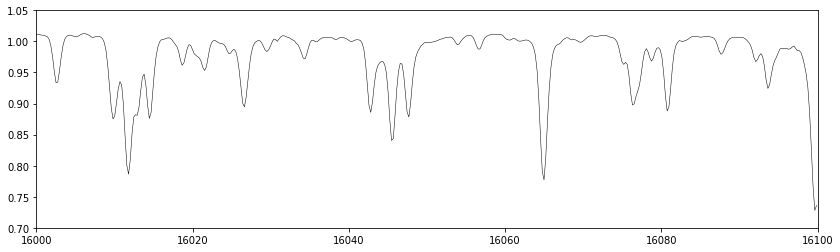

In [2]:
spec_err = 1e-2*np.ones(len(wavelength))

# for a single-star model, the format of "labels" is [Teff, logg, [Fe/H], [Mg/Fe], v_macro, v_los]. 
real_labels = [5800, 4.44, 0, 0, 5, 10] # redshift by 10 km/s. 
real_spec = spectral_model.get_normalized_spectrum_single_star(labels = real_labels, 
                NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
                spec_err = spec_err)

# zoom in on a small region of the spectrum so we can see what's going on.
lambda_min, lambda_max = 16000, 16100# for plotting 
m = (wavelength < lambda_max) & (wavelength > lambda_min)
plt.figure(figsize=(14, 4))
plt.plot(wavelength[m], real_spec[m], 'k', lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.7, 1.05)

Now let's add some noise to this model spectrum, and then fit it to see if we can recover the labels we put in. 

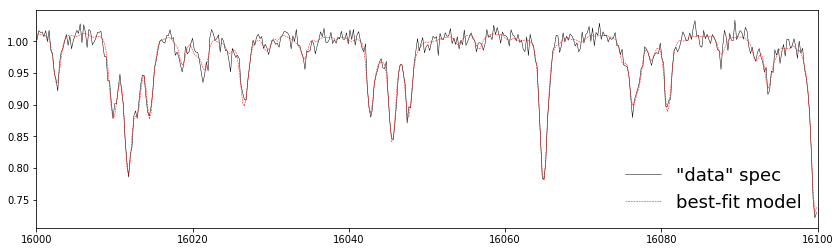

In [3]:
data_spec = real_spec + 0.01*np.random.randn(len(real_spec))

popt, pcov, model_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec, 
        spec_err = spec_err, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        p0 = None, num_p0 = 1)

plt.figure(figsize=(14, 4))
m = (wavelength < lambda_max) & (wavelength > lambda_min)
plt.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = '"data" spec')
plt.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = 'best-fit model')
plt.xlim(lambda_min, lambda_max)
plt.legend(loc = 'best', frameon = False, fontsize = 18)

In [4]:
# verify that our best-fit labels are close to what we put in. 
print(popt)

[ 5.78209188e+03  4.42872567e+00 -8.37952943e-03 -2.33132947e-03
  5.74494035e+00  9.93352533e+00]


Now let's predict the spectrum of an unresolved binary. 

(0.75, 1.05)

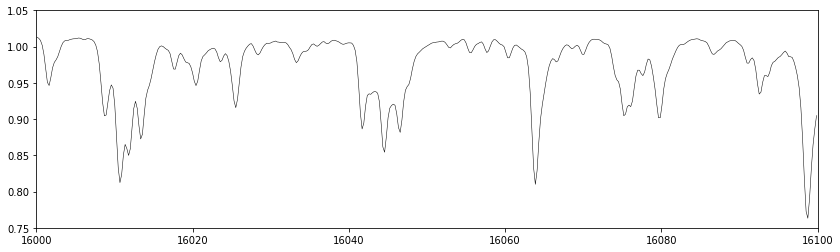

In [5]:
# predict a binary spec
# for a binary, the labels are [Teff1, logg1, [Fe/H], [Mg/Fe], v_macro1, v_macro2, v_los1, v_los2]
real_bin_labels = [5800, 4.44, 0, 0, 0.7, 2, 5, -10, 10]
specerr = 1e-2*np.ones(len(wavelength))
real_bin_spec = spectral_model.get_normalized_spectrum_binary(labels = real_bin_labels, 
                NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
                NN_coeffs_R = NN_coeffs_R, NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2,
                spec_err = specerr)

plt.figure(figsize=(14, 4))
m = (wavelength < lambda_max) & (wavelength > lambda_min)
plt.plot(wavelength[m], real_bin_spec[m], 'k', lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.75, 1.05)

Again, let's add some noise and then fit the spectrum. We'll fit it with both a single-star model and a binary model, and then compare the fits. 

Notice that we always pass the fitting function an arguement "num_p0". This determines how many different "walkers" to initialize for the optimizer, to minimize the chance of it's converging on a local mininimum. For a simple single-star model, there's little danger of this happening, but it's more likely for more complicated models with more labels. 

How long the code takes to run scales linearly with the number of walkers.

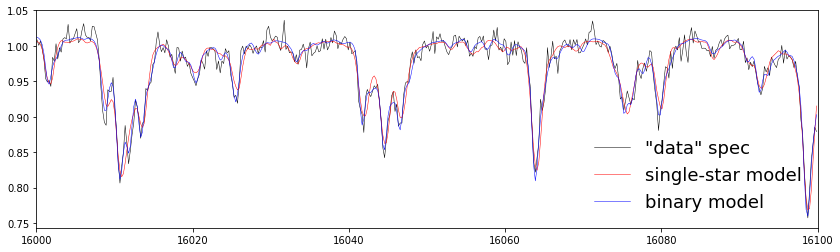

In [6]:
data_bin_spec = real_bin_spec + 0.01*np.random.randn(len(real_bin_spec))

# fit single-star model
popt_single, pcov, single_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = real_bin_spec, 
        spec_err = specerr, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        p0 = None, num_p0 = 1)

# fit binary model. 
# use the best-fit single-star model ("popt_single") as a starting guess. 
popt_binary, pcov, bin_spec = fitting.fit_normalized_spectrum_binary_model(norm_spec = real_bin_spec, 
        spec_err = specerr, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        NN_coeffs_R = NN_coeffs_R, NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2,
        p0_single = popt_single, num_p0 = 10)


plt.figure(figsize=(14, 4))
m = (wavelength < lambda_max) & (wavelength > lambda_min)
plt.plot(wavelength[m], data_bin_spec[m], 'k', lw=0.5, label = '"data" spec')
plt.plot(wavelength[m], single_spec[m], 'r', lw=0.5, label = 'single-star model')
plt.plot(wavelength[m], bin_spec[m], 'b', lw=0.5, label = 'binary model')
plt.xlim(lambda_min, lambda_max)
plt.legend(loc = 'best', frameon = False, fontsize= 18)

In [7]:
# unsurprisingly, the single-star model isn't a very good fit, but the binary model is. 
# verify that our best-fit labels are close to what we put in. 
print(popt_binary)

[ 5.72428434e+03  4.40086457e+00 -3.38014621e-02  1.38821970e-02
  7.38676667e-01  1.62031137e+00  6.45499621e+00 -1.00485756e+01
  9.90639952e+00]


Now that we've seen how to generate and fit model spectra, let's download an actual APOGEE spectrum. Here we'll download a "combined" spectrum. 

We'll start with a target that is likely a binary, but is not an "obvious" one. I.e., there's no large velocity offset. 

Note: downloading the spectra requires you to have Jo Bovy's Apogee package installed.

(16000, 16100)

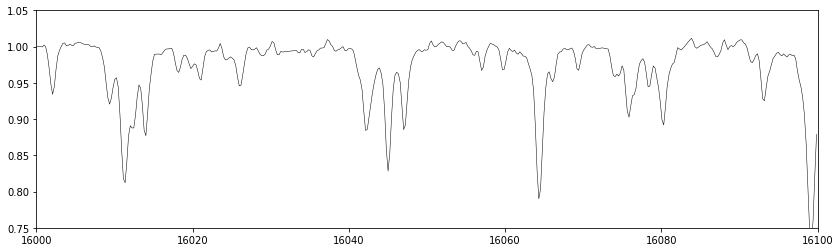

In [9]:
from binspec import process_spectra
apogee_id = '2M18513961+4338099'
spec, spec_err = process_spectra.get_combined_spectrum_single_object(apogee_id = apogee_id, 
                    catalog = None, save_local = False)

plt.figure(figsize=(14, 4))
m = (spec_err < 0.1) & (wavelength < lambda_max) & (wavelength > lambda_min)
 # mask low SNR pixels
plt.plot(wavelength[m], spec[m], 'k', lw=0.5)
plt.ylim(0.75, 1.05)
plt.xlim(lambda_min, lambda_max)

Now let's fit this spectrum with a single-star model and a binary model!

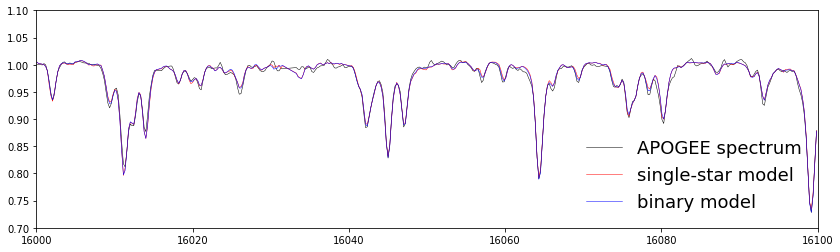

In [10]:
# fit single-star model
popt_single, pcov, single_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = spec, 
        spec_err = spec_err, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        p0 = None, num_p0 = 1)

# fit binary model. 
popt_binary, pcov, bin_spec = fitting.fit_normalized_spectrum_binary_model(norm_spec = spec, 
        spec_err = spec_err, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        NN_coeffs_R = NN_coeffs_R, NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2,
        p0_single = popt_single, num_p0 = 10)

plt.figure(figsize=(14, 4))
plt.plot(wavelength[m], spec[m], 'k', lw=0.5, label = 'APOGEE spectrum')
plt.plot(wavelength[m], single_spec[m], 'r', lw=0.5, label = 'single-star model')
plt.plot(wavelength[m], bin_spec[m], 'b', lw=0.5, label = 'binary model')
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.7, 1.1)
plt.legend(loc = 'best', frameon = False, fontsize= 18)

The binary model looks like a better fit, though the differences are sublte. You can change the axis limits to zoom in on particular lines or explore other parts of the spectrum. 

Let's compare the $\chi^2$ of the single and binary model. 

In [11]:
chi2_diff = utils.get_chi2_difference(norm_spec=spec, spec_err=spec_err, 
                norm_model_A = single_spec, norm_model_B = bin_spec)
print(chi2_diff)

1355.1496889024056


Now that we've fit a not-obvious binary (one with a small velocity offset), let's look at one with a bigger velocity offset between the two stars. We'll download the spectrum and fit it in one go. 

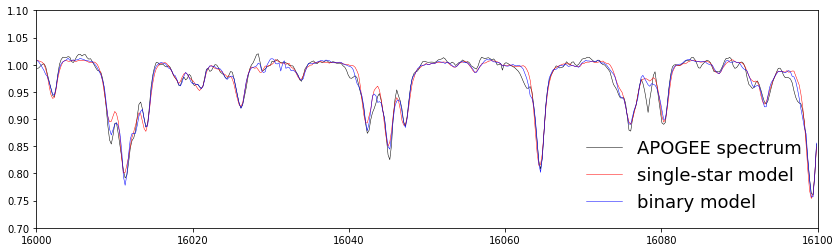

In [12]:
apogee_id = '2M13080617+1753494'
spec, spec_err = process_spectra.get_combined_spectrum_single_object(apogee_id = apogee_id, 
                    catalog = None, save_local = False)

# fit single-star model
popt_single, pcov, single_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = spec, 
        spec_err = spec_err, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        p0 = None, num_p0 = 1)

# fit binary model. 
popt_binary, pcov, bin_spec = fitting.fit_normalized_spectrum_binary_model(norm_spec = spec, 
        spec_err = spec_err, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        NN_coeffs_R = NN_coeffs_R, NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2,
        p0_single = popt_single, num_p0 = 10)

m = (spec_err < 0.1) & (wavelength < lambda_max) & (wavelength > lambda_min)
plt.figure(figsize=(14, 4))
plt.plot(wavelength[m], spec[m], 'k', lw=0.5, label = 'APOGEE spectrum')
plt.plot(wavelength[m], single_spec[m], 'r', lw=0.5, label = 'single-star model')
plt.plot(wavelength[m], bin_spec[m], 'b', lw=0.5, label = 'binary model')
plt.xlim(16000, 16100)
plt.ylim(0.7, 1.1)
plt.legend(loc = 'best', frameon = False, fontsize= 18)

Here, the differences between the best-fit binary and single-star models are more obvious. Since the velocity offset between the two stars in the best-fit binary model appears non-neglible, we should fit the spectra from individual visits, in case the spectrum changes significantly from one visit to the next.

Let's download and plot the spectra from each visit. 

(0.7, 1.6)

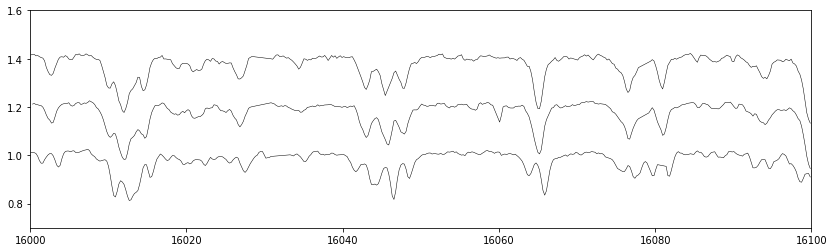

In [14]:
all_specs, all_err, all_snr, all_hjd, all_vhelio = \
    process_spectra.download_visit_spectra_single_object_and_renormalize(
        apogee_id = apogee_id, p0_single_combined = popt_single, 
        NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux,
        allvisit_cat = None, snr_min = 30)

plt.figure(figsize=(14, 4))
for i, spec in enumerate(all_specs):
    m = (all_err[i] < 0.1) & (wavelength < lambda_max) & (wavelength > lambda_min)
    plt.plot(wavelength[m], spec[m] + 0.2*i, 'k', lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.7, 1.6)

Yup, the spectrum definitely looks like it's changing significantly from one visit to the next (most significantly, from the first (bottom) spectrum to the second). Let's fit these visit spectra simultaneously using an SB2 model. 

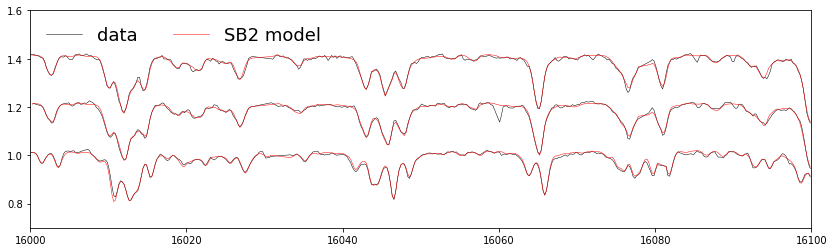

In [15]:
sb2_labels, pcov, sb2_models = fitting.fit_visit_spectra_sb2_model(
        norm_spectra = all_specs, spec_errs = all_err,
        NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        NN_coeffs_R = NN_coeffs_R, NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2,
        v_helios = all_vhelio, p0_combined = popt_binary, num_p0 = 5)

plt.figure(figsize=(14, 4))
for i, spec in enumerate(all_specs):
    m = (all_err[i] < 0.1) & (wavelength < lambda_max) & (wavelength > lambda_min)
    if i == 0: data_label, model_label = 'data', 'SB2 model'
    else: data_label, model_label = None, None
    plt.plot(wavelength[m], spec[m] + 0.2*i, 'k', lw=0.5, label = data_label)
    plt.plot(wavelength[m], sb2_models[i][m] + 0.2*i, 'r', lw=0.5, label = model_label)

plt.xlim(lambda_min, lambda_max)
plt.ylim(0.7, 1.6)
plt.legend(loc = 'upper left', frameon = False, ncol = 2, fontsize = 18)

Looks like a good fit. Let's see what the best-fit labels are. The format of the label vector returned for an SB2 model is format is [Teff1, logg1, [Fe/H], [Mg/Fe], q_spec, v_macro1, v_macro2, q_dyn, gamma, dv1_i],
where i = 1...N_visits and dv_i is the velocity of the primary at each visit. 

If you aren't sure what the labels for a particular model are, you can check in spectral_model.py

In [16]:
print(sb2_labels)

[ 5.81613398e+03  4.44333583e+00  1.11953042e-01 -4.44968575e-02
  8.39541154e-01  2.81615771e+00  2.98151241e+00  8.34879523e-01
  1.06085562e+01  2.79617097e+01  1.67868645e+01  1.57842628e+01]


We note that q_spec and q_dyn are both about 0.83. That's good. 

Finally, let's try fitting an SB1. First, we'll download and fit the combined spectrum.


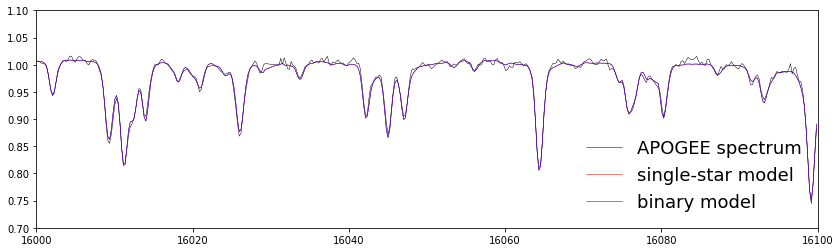

In [17]:
apogee_id = '2M13381097+5620250'
spec, spec_err = process_spectra.get_combined_spectrum_single_object(apogee_id = apogee_id, 
                    catalog = None, save_local = False)

# fit single-star model
popt_single, pcov, single_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = spec, 
        spec_err = spec_err, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        p0 = None, num_p0 = 1)

# fit binary model. 
popt_binary, pcov, bin_spec = fitting.fit_normalized_spectrum_binary_model(norm_spec = spec, 
        spec_err = spec_err, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        NN_coeffs_R = NN_coeffs_R, NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2,
        p0_single = popt_single, num_p0 = 10)

m = (spec_err < 0.1) & (wavelength < lambda_max) & (wavelength > lambda_min)
plt.figure(figsize=(14, 4))
plt.plot(wavelength[m], spec[m], 'k', lw=0.5, label = 'APOGEE spectrum')
plt.plot(wavelength[m], single_spec[m], 'r', lw=0.5, label = 'single-star model')
plt.plot(wavelength[m], bin_spec[m], 'b', lw=0.5, label = 'binary model')
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.7, 1.1)
plt.legend(loc = 'best', frameon = False, fontsize= 18)


In [18]:
chi2_diff = utils.get_chi2_difference(norm_spec=spec, spec_err=spec_err, 
                norm_model_A = single_spec, norm_model_B = bin_spec)
print(chi2_diff)

12.454045647324165


Hmmm, for this target, the binary model fit is not obviously better, and the $\chi^2$ difference for the combined spectrum is very small (small enough that it wouldn't pass our model selection criteria to consider it a reliable binary). 

However, if we look at the APOGEE-supplied v_helios, we'll find that this target is RV variable. 

Therefore, we'll download the individual-visit spectra, and we'll try fitting them with both an SB1 model and a genuine single-star model. 

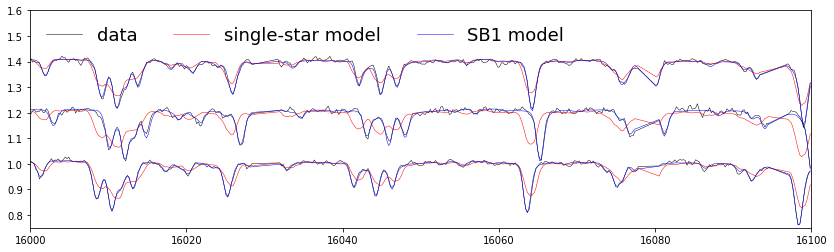

In [19]:
# get the visit spectra
all_specs, all_err, all_snr, all_hjd, all_vhelio = \
    process_spectra.download_visit_spectra_single_object_and_renormalize(
        apogee_id = apogee_id, p0_single_combined = popt_single, 
        NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux,
        allvisit_cat = None, snr_min = 30)

# fit them with a single-star model
single_labels, pcov, single_models = fitting.fit_visit_spectra_single_star_model(
        norm_spectra = all_specs, spec_errs = all_err, NN_coeffs_norm = NN_coeffs_norm,
        NN_coeffs_flux = NN_coeffs_flux, v_helios = all_vhelio, p0 = popt_single, num_p0 = 1)

# fit them with an SB1 model
sb1_labels, pcov, sb1_models = fitting.fit_visit_spectra_sb1_model(
        norm_spectra = all_specs, spec_errs = all_err, NN_coeffs_norm = NN_coeffs_norm, 
        NN_coeffs_flux = NN_coeffs_flux, v_helios = all_vhelio, p0 = popt_single, num_p0 = 5)

plt.figure(figsize=(14, 4))
for i, spec in enumerate(all_specs):
    m = (all_err[i] < 0.1) & (wavelength < lambda_max) & (wavelength > lambda_min)
    if i == 0: data_label, sb1_label, single_label = 'data', 'SB1 model', 'single-star model'
    else: data_label, sb1_label, single_label = None, None, None

    plt.plot(wavelength[m], spec[m] + 0.2*i, 'k', lw=0.5, label = data_label)
    plt.plot(wavelength[m], single_models[i][m] + 0.2*i, 'r', lw=0.5, label = single_label)
    plt.plot(wavelength[m], sb1_models[i][m] + 0.2*i, 'b', lw=0.5, label = sb1_label)
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.75, 1.6)
plt.legend(loc = 'upper left', frameon = False, ncol = 3, fontsize = 18)

It's pretty clear that the spectrum is changing from one visit to the next, so the single-star model (which requires constant v_helio across visits) won't be able to get a good fit. But the SB1 model does achieve a good fit, and if you tried an SB2 model, you'd find that it couldn't do any better. 

Let's look at the labels of the best-fit SB1 model, which are in the format [Teff, logg, [Fe/H], [Mg/Fe], v_macro, dv_i], where i = 1..N_visits is the velocity at each visit. 

In [20]:
print(sb1_labels)

[ 6.05304906e+03  4.22038959e+00  3.19397736e-02 -9.55707797e-02
  8.27411087e+00 -1.43351623e+01  1.70064601e+01 -2.60268342e+00]


**One practical note:**

Fitting combined spectra with single/binary models is pretty fast. If you pass the fitting function to a Python multiprocessing Pool, you should be able to comfortably fit 10,000 targets in < 1 day on a single node of a typical cluster. 

On the other hand, fitting visit spectra can be fairly slow, because the models get more complicated and each additional visit adds (at least) one more free parameter. A small fraction of targets have 30+ visits, which means that the optimization for a complicated model can entail optimizing in a function of 100+ free parameters. In this case, a single target can keep your node working all day. 

Therefore, it makes sense to start out by fitting combined spectra. Afterward, you can switch to fitting visit spectra for targets where it makes sense to; i.e., targets that are RV variable or have combined spectra that appear to be binaries with significant velocity offsets. In cases where many visits need to be fit simultaneously, it can also help to first fit them individually (which is faster) and then use the velocities from this to initialize a good guess for simultaneous fitting. 